# Demo of Coregionalisation for Calibration

We can calibrate one sensor with another, using coregionalisation.

We need to estimate the vector, $W$, to produce the rank-one matrix $W W^\top$.

This is done below by looking at the RMSE, however it would be better to use the log-likelihood.

In particular we should use a laplace approximation, or the CCD approximation to get the uncertainty over this coregionalisation. We can then make predictions with the uncertainty of the coregionalisation.

The idea would be that additional observations would reduce this uncertainty.

We could also in the future look at the coregionalisation such that this varies over time...

In [1]:
#import GPy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def sim(x):
    if x[1]==0:
        v = x[0] #pollution rising linearly with time in location 0
    if x[1]==1:
        v = np.sin(x[0]) #pollution rising as square of time in loc 1
    scales = [1,0.5,0.3]
    return scales[int(x[2])]*v
    
X = np.zeros([0,3])

N = 6 #number of time points
#time, space, region
#fixed station 0
X = np.r_[X,np.c_[np.arange(N)[:,None],np.full(N,0.0)[:,None],np.full(N,0)[:,None]]]
#mobile
X = np.r_[X,np.c_[np.arange(N)[:,None],np.full(N,1.0)[:,None],np.full(N,1)[:,None]]]
X[-3:,1] = 0
#fixed station 1
X = np.r_[X,np.c_[np.arange(N)[:,None],np.full(N,1.0)[:,None],np.full(N,2)[:,None]]]


Y = np.empty([len(X),1])
for i,x in enumerate(X):
    Y[i,0] = sim(x)
#latent real values
#X = np.r_[X,np.c_[np.arange(4)[:,None],np.full(4,0.0)[:,None],np.full(4,3)[:,None]]]
#X = np.r_[X,np.c_[np.arange(4)[:,None],np.full(4,1.0)[:,None],np.full(4,3)[:,None]]]



def k(X,X2,W,l_time=2.0,l_dist=0.1):
    coregmat = W.T @ W
    k_time = np.exp(-(X[0]-X2[0])**2/(2*l_time))
    k_dist = np.exp(-(X[1]-X2[1])**2/(2*l_dist))
    k_coreg = coregmat[int(X[2]),int(X2[2])]
    return k_time * k_dist * k_coreg

def calcK(X,W = np.array([[1,1,1]])):
    K = np.empty([len(X),len(X)])
    for i,x in enumerate(X):
        for j,x2 in enumerate(X):
            K[i,j] = k(x,x2,W)
    return K

def calckstar(xtest,X,W = np.array([[1,1,1]])):
    kstar = np.empty([len(X),1])
    for i in range(len(X)):
        kstar[i,:]=k(xtest,X[i,:],W)
    return kstar

leastrmse = np.inf
leastWs = None
for W0 in np.arange(0.4,6.01,0.6):
    for W1 in np.arange(0.4,6.01,0.6):
        for W2 in np.arange(0,6.01,0.6):
            W = np.array([[W0,W1,W2]])
            rmse = []
            for dropi in range(len(X)):
                Xdrop = np.delete(X,dropi,0)
                Ydrop = np.delete(Y,dropi,0)
                K = calcK(Xdrop,W)
                xtest = X[dropi,:]
                kstar = calckstar(xtest,Xdrop,W)    
                #kstarstar = k(xtest,xtest)
                Kinv = np.linalg.inv(K+np.eye(len(K)))
                predy = kstar.T@Kinv@Ydrop
                rmse.append((predy-Y[dropi])**2)
                #kstarstar - kstar.T@Kinv@kstar
            rmse = np.sqrt(np.mean(np.array(rmse)))
            print(W,rmse)
            if rmse<leastrmse:
                leastrmse = rmse
                leastWs = W

In [4]:
leastWs

array([[5.8, 2.8, 1.8]])

In [5]:
np.array([1,0.5,0.3])*5.8

array([5.8 , 2.9 , 1.74])

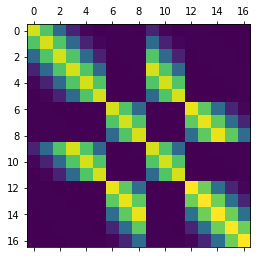

In [6]:
plt.matshow(K)